In [1]:
import numpy as np
import os
import sys
import pandas as pd
from PIL import Image
import random

## Expression Classification
### Based on the Jaffe dataset - [http://www.kasrl.org/jaffedb_info.html](http://www.kasrl.org/jaffedb_info.html)

In [2]:
path = 'data/jaffe'

In [3]:
readme = '/README'

In [4]:
with open(path + readme) as f:
    info = f.readlines()

In [5]:
header = info[38].strip('\#').strip('\n').strip().split(' ')

In [6]:
header = header[:-1]

In [7]:
header

['HAP', 'SAD', 'SUR', 'ANG', 'DIS', 'FEA']

In [8]:
data = [line.split(' ')[1:-1] for line in info[40:259]]
names = [line.split(' ')[-1].strip('\n') for line in info[40:259]]
# data = [line.split(' ') for line in info[40:259]]

In [9]:
df = pd.DataFrame(data, columns=header).astype(float)

---

In [10]:
photos = list(filter(lambda x: x != 'README' and x != '.DS_Store', sorted(os.listdir(path))))

In [11]:
def parse_photo(photo):
    fname = photo.split('.t')[0]
    fname = fname.split('.')
    fname = '-'.join(fname[:-1])
    return fname

In [12]:
photo_dict = {parse_photo(photo):photo for photo in photos}

In [13]:
df = pd.concat([df, pd.Series(names, name='NAME')], axis=1)

In [14]:
df.shape

(219, 7)

In [15]:
for i, row in df.iterrows():
    if row.NAME not in photo_dict:
        df = df.drop(i, axis=0)

df = df.reset_index(drop=True)

In [16]:
df.shape

(212, 7)

In [17]:
df = df.assign(PIC = df.NAME.apply(lambda x: photo_dict[x]))

In [18]:
def get_image(fname, label=None):
    global path
    image_path = "{}/{}".format(path, fname)
    print(label)
    return Image.open(image_path)

In [19]:
def get_max_col(df_, row_):
    ix = df_.iloc[row_,:].values.argmax()
    return df_.columns[ix]

In [20]:
X = df.drop(['NAME', 'PIC'], axis=1)
y = df.NAME

SUR


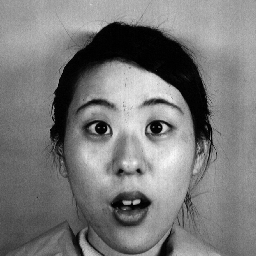

In [21]:
photo_ix = 97
get_image(df.PIC[photo_ix], 
          label=get_max_col(X, photo_ix))

ANG


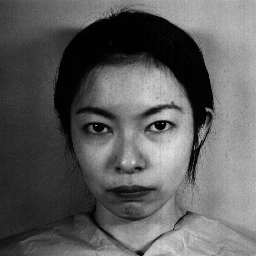

In [22]:
photo_ix = 204
get_image(df.PIC[photo_ix], 
          label=get_max_col(X, photo_ix))

In [23]:
y = X.apply(np.argmax, axis=1)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


---

In [24]:
from sklearn.cluster import KMeans

In [25]:
km7 = KMeans(7)

km7.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [26]:
df_cluster = df.assign(km7 = km7.labels_)

In [27]:
for col in X.columns:
    df_cluster.plot.scatter('km7', col)

In [28]:
km2 = KMeans(2)

km2.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [29]:
df_cluster = df.assign(km2 = km2.labels_)

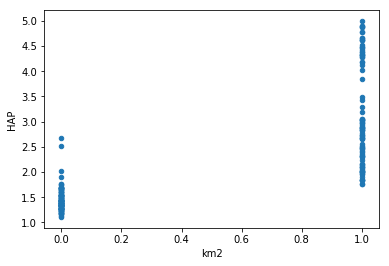

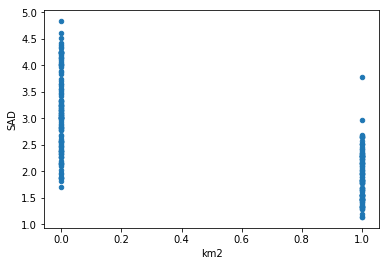

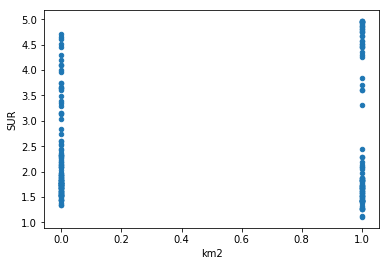

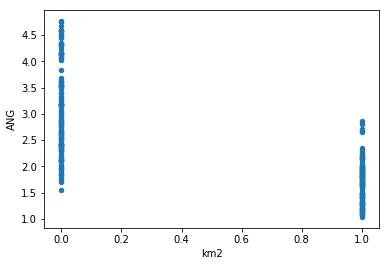

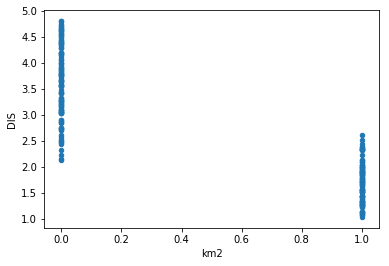

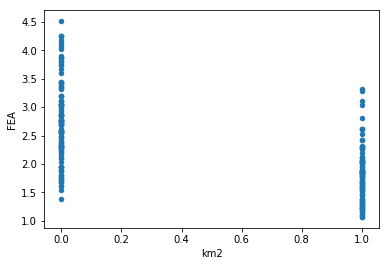

In [30]:
for col in X.columns:
    df_cluster.plot.scatter('km2', col)

---

In [31]:
import tensorflow as tf
import tensorflow_hub as hub

In [32]:
 module_features = hub.Module(
    "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/1",
    trainable=True, tags={'train'}
)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


In [33]:
height, width = hub.get_expected_image_size(module_features)

In [34]:
height, width

(331, 331)

In [35]:
def pad_image(image_, height_):
    # https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
    desired_size = height_
    old_size = image_.size  # old_size[0] is in (width, height) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    im = image_.resize(new_size, Image.ANTIALIAS)

    # create a new image and paste the resized on it
    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
    
    return new_im

image_path = lambda fname: "{}/{}".format(path, fname)
def load_prepare_image(fname):
    global height
    img = Image.open(fname)
    pad = pad_image(img, height)
    return tf.image.convert_image_dtype(pad, dtype=tf.float32)

None


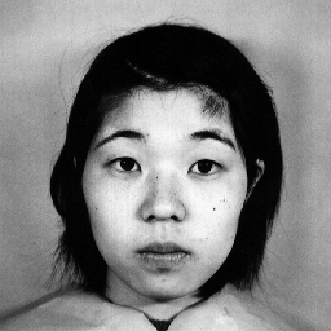

In [36]:
pad_image(get_image(df.PIC[0]), height)

In [37]:
image_tf = df.PIC.apply(lambda x: load_prepare_image(image_path(x))).values

In [38]:
image_tf.shape

(212,)

In [39]:
features = module_features(image_tf.tolist())

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [40]:
features.shape

TensorShape([Dimension(212), Dimension(4032)])

In [41]:
NUM_CLASSES = 6
logits = tf.layers.dense(features, NUM_CLASSES)
probabilities = tf.nn.softmax(logits)

In [42]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    probs = sess.run(probabilities)

In [43]:
rand_ix = random.sample(range(212), 10)
for i in rand_ix:
    pred = X.columns[pd.Series(probs[i]).values.argmax()]
    get_image(df.PIC[i], 
              label='Actual: {}, Predicted: {}'.format(get_max_col(X, i), pred))

Actual: HAP, Predicted: FEA
Actual: HAP, Predicted: DIS
Actual: HAP, Predicted: FEA
Actual: DIS, Predicted: FEA
Actual: ANG, Predicted: FEA
Actual: ANG, Predicted: FEA
Actual: HAP, Predicted: FEA
Actual: SUR, Predicted: FEA
Actual: SAD, Predicted: FEA
Actual: SAD, Predicted: DIS


---

In [54]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [45]:
le_y = LabelEncoder()

y_enc = pd.DataFrame(le_y.fit_transform(y))

In [57]:
n_samples = len(y.index)
testing = random.sample(range(n_samples), 30)
training = list(filter(lambda x: x not in testing,range(n_samples)))

X_train, X_test = X.iloc[training,], X.iloc[testing, ]
y_train, y_test = y_enc.iloc[training], y_enc.iloc[testing]

In [58]:
X_train.shape

(182, 6)

In [59]:
y_train.shape

(182, 1)

In [60]:
lr = LogisticRegression()

In [61]:
lr.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
results = pd.DataFrame(columns=['Pred', 'Actual'])

In [63]:
results.Pred = lr.predict(X_test)
results.Actual = y_test.values

In [92]:
import warnings
warnings.filterwarnings('ignore')

In [94]:
results = results.assign(Pred_enc = results.Pred.apply(le_y.inverse_transform),
                         Actual_enc = results.Actual.apply(le_y.inverse_transform))

In [95]:
results

Pred  Actual Pred_enc Actual_enc
0      3       3      HAP        HAP
1      5       5      SUR        SUR
2      3       3      HAP        HAP
3      4       4      SAD        SAD
4      3       3      HAP        HAP
5      1       1      DIS        DIS
6      1       1      DIS        DIS
7      0       0      ANG        ANG
8      3       3      HAP        HAP
9      3       3      HAP        HAP
10     0       0      ANG        ANG
11     0       0      ANG        ANG
12     3       3      HAP        HAP
13     3       3      HAP        HAP
14     4       4      SAD        SAD
15     5       5      SUR        SUR
16     5       5      SUR        SUR
17     0       0      ANG        ANG
18     4       4      SAD        SAD
19     0       1      ANG        DIS
20     5       5      SUR        SUR
21     5       5      SUR        SUR
22     4       4      SAD        SAD
23     1       1      DIS        DIS
24     1       1      DIS        DIS
25     3       3      HAP        HAP
26     4       2      SAD        FEA
27     3       3      HAP        HAP
28     0       0      ANG        ANG
29     4       4      SAD        SAD